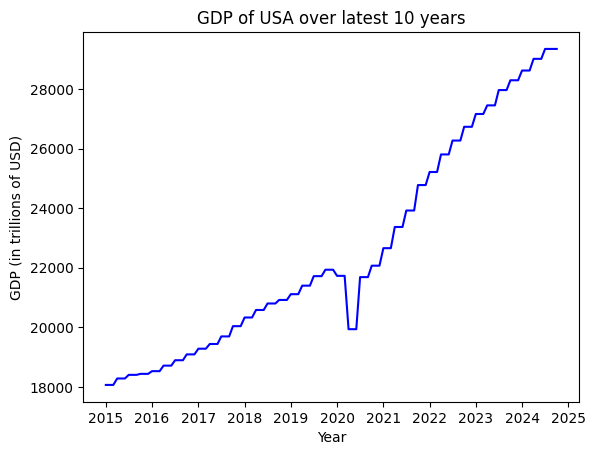

In [1]:
!pip install reportlab
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
from reportlab.platypus import Table, TableStyle
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter

observation_start = "2015-01-01"
#observation_end = "2024-09-01"
observation_end = (datetime.now().replace(day=1) + relativedelta(months=1) - relativedelta(days=1)).strftime("%Y-%m-%d")

#retrieve the data from FRED using pdr
data = pdr.DataReader(["GDP","UNRATE"], "fred", observation_start, observation_end)

#let's Add a Year column for the chart we paln to make
data['year'] = data.index.strftime("%Y")
#filling Nan values with ffill() for quartely GDP data
data['GDP'] = data['GDP'].ffill()

#creating table for the data and getting the column order from Jan to Dec
unemployment_data = data[['UNRATE']].copy()
unemployment_data['year'] = data.index.year.astype(int)
unemployment_data['month'] = data.index.strftime("%b")
unemployment_table = unemployment_data.pivot(index='year', columns='month',values='UNRATE')
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
unemployment_table = unemployment_table.reindex(columns=month_order)

#plot GDP w/ matplotlib
plt.plot(data.index, data['GDP'], color='blue')
plt.xlabel('Year')
plt.ylabel('GDP (in trillions of USD)')
plt.title('GDP of USA over latest 10 years')

#saving the chart
gdp_chart = "gdp_chart.png"
plt.savefig(gdp_chart)
#plt.show() #uncomment to check it out

#Now let's create the pdf document
doc = canvas.Canvas("us_economy.pdf", pagesize=letter)
width, height = letter

#add title to document
doc.setTitle("US Economy Over the Latest 10 years")
doc.setFont('Helvetica', 24)
doc.drawString(100, height - 50, 'US Economy Over the Latest 10 years')

#Add GDP chart we made earlier
doc.drawImage(gdp_chart, 100, height - 300, width=400, height=200)

#Add unemp rate table
doc.setFont('Helvetica', 12)
doc.drawString(200, height - 350, 'Unemployment Rate by Year and Month')

#convert unmep table df to a list for Reportlab table and set column widths
table_data = [['year'] + month_order]
table_data += [[int(col[0])] + col[1:] for col in unemployment_table.reset_index().values.tolist()]

col_widths = [60] + 12 * [30] #60 for the year and 30 for months columns

#create and style the table
table = Table(table_data, colWidths=col_widths)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0),(-1,0), colors.grey),
    ('ALIGN', (0,0),(-1,0), 'CENTER'),
    ('GRID', (0,0),(-1,-1),1, colors.black)
]))

#position table below chart
table.wrapOn(doc, width, height)
table.drawOn(doc, 100, height - 550)

#save the pdf
doc.save()







In [6]:
!pip install reportlab
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
from reportlab.platypus import Table, TableStyle
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter

def get_observation_dates():
    '''Returns observation start and end dates.'''
    observation_start = "2015-01-01"
    observation_end = (datetime.now().replace(day=1) + relativedelta(months=1) - relativedelta(days=1)).strftime("%Y-%m-%d")
    return observation_start, observation_end

def preprocess_add_to_pdf(pdf, series, title0, title1, ylabel, bservation_start, observation_end):
    '''
    Fetches data from FRED API, preprocesses it, creates GDP chart and UR table
    and adds both to the pdf
    '''
    #retrieve the data from FRED using pdr
    data = pdr.DataReader(series, "fred", observation_start, observation_end)

    #let's Add a Year column for the chart we plan to make and fill forward gdp
    data['year'] = data.index.strftime("%Y")
    data[series[0]] = data[series[0]].ffill()

    #creating table for the data and getting the column order from Jan to Dec
    unemployment_data = data[[series[1]]].copy()
    unemployment_data['year'] = data.index.year.astype(int)
    unemployment_data['month'] = data.index.strftime("%b")
    unemployment_table = unemployment_data.pivot(index='year', columns='month', values=series[1])
    month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    unemployment_table = unemployment_table.reindex(columns=month_order)

    #plot GDP w/ matplotlib
    chart_file = f"{series[0]}_chart.png"
    plt.figure(figsize=(8,4)) #new - standardizing the size of the chart
    plt.plot(data.index, data[series[0]], color='blue')
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.title(title0)
    plt.savefig(chart_file)
    plt.close()

    #add chart to pdf
    width, height = letter
    pdf.drawImage(chart_file, 100, height - 300, width=400, height=200)
    pdf.setFont('Helvetica', 10)
    pdf.drawString(300, height - 350, title1)

    #Add unemp rate table
    table_data = [['year'] + month_order]
    table_data += [[int(col[0])] + col[1:] for col in unemployment_table.reset_index().values.tolist()]
    col_widths = [60] + 12 * [30] #60 for the year and 30 for months columns

    #create and style the table
    table = Table(table_data, colWidths=col_widths)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0,0),(-1,0), colors.grey),
        ('ALIGN', (0,0),(-1,0), 'CENTER'),
        ('GRID', (0,0),(-1,-1),1, colors.black)
    ]))

    table.wrapOn(pdf, width, height)
    table.drawOn(pdf, 100, height - 550)
    pdf.showPage()

def create_pdf():
    '''creates the final pdf'''
    observation_start, observation_end = get_observation_dates()
    pdf = canvas.Canvas("us_economy.pdf", pagesize=letter)

    #New front page
    width, height = letter
    pdf.setTitle("US economy and State Economies")
    pdf.setFont("Helvetica", 24)
    pdf.drawString(125, height - 350, "US economy and State Economies")
    pdf.drawString(250, height - 400, "latest 10 years")
    pdf.showPage()

    #add our sections for USA, California and Texas and NY
    preprocess_add_to_pdf(pdf, ['GDP','UNRATE'], 'GDP of USA', 'Unemp Rate USA', 'GDP (in billions USD)', observation_start, observation_end)
    preprocess_add_to_pdf(pdf, ['CANGSP','CAURN'], 'California GDP', 'Unemp Rate California', 'GDP (in billions USD)', observation_start, observation_end)
    preprocess_add_to_pdf(pdf, ['TXNGSP','TXURN'], 'Texas GDP', 'Unemp Rate Texas', 'GDP (in billions USD)', observation_start, observation_end)
    preprocess_add_to_pdf(pdf, ['NYNGSP','NYURN'], 'NY GDP', 'Unemp Rate NY', 'GDP (in billions USD)', observation_start, observation_end)

    pdf.save() #saving the pdf

create_pdf()





